In [2]:
from app.datasets.unique_locations_48h import UniqueLocationsDataset48h
from app.settings import Settings
from app.logger import logger
from Geohash import encode
from os import path

import pandas as pd


settings = Settings()

RAW_DATASET_FILE = path.join(settings.file_system.caches_path, "unique_locations_raw_dataset_48h.pkl")
PROCESSED_DATASET_FILE = path.join(settings.file_system.caches_path, f"unique_locations_processed_dataset_48h.pkl")

In [3]:
def add_geohashes(df: pd.DataFrame) -> None:
    logger.info("Calculating geohashes")
    
    for precision in range(4,7): # 4..6
    
        df[f'geohashes_{precision}'] = df[['latitude','longitude']].apply(
            lambda row: encode(
                float(row['latitude']),
                float(row['longitude']),
                precision
            )
        , axis=1)

In [4]:
def load_records() -> pd.DataFrame:
    if path.isfile(RAW_DATASET_FILE):
        logger.info('Raw Datafile already exists, loading file...')
        df = pd.read_pickle(RAW_DATASET_FILE)
    else:
        dataset = UniqueLocationsDataset48h()
        df = dataset.load_dataset()

        logger.info(f"saving {RAW_DATASET_FILE}")
        df.to_pickle(RAW_DATASET_FILE)
    return df
    

def prepare_records() -> pd.DataFrame:
    if path.isfile(PROCESSED_DATASET_FILE):
        logger.info('Processed Datafile already exists, loading file...')
        df = pd.read_pickle(PROCESSED_DATASET_FILE)
    else:
        df = load_records()
        
        add_geohashes(df)

        logger.info(f"saving {PROCESSED_DATASET_FILE}")
        # save datafile
        df.to_pickle(PROCESSED_DATASET_FILE)
    return df


## Prepare data
Load records from snowflake (or file if cached), calculate Geohashes and Boundary coordinates

In [5]:
df = load_records()

INFO 17820 4524183040 2021-07-07 18:03:59,372 root.load_dataset:30 - Fetching data according to unique_locations_48h.sql
INFO 17820 4524183040 2021-07-07 18:03:59,374 snowflake.connector.connection.__init__:257 - Snowflake Connector for Python Version: 2.4.6, Python Version: 3.9.5, Platform: macOS-11.4-x86_64-i386-64bit
INFO 17820 4524183040 2021-07-07 18:03:59,376 snowflake.connector.connection.__config:868 - This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
INFO 17820 4524183040 2021-07-07 18:03:59,377 snowflake.connector.connection.__config:886 - Setting use_openssl_only mode to False
INFO 17820 4524183040 2021-07-07 18:04:00,121 snowflake.connector.cursor.execute:637 - query: [USE role PROD_FULL_READER]
INFO 17820 4524183040 2021-07-07 18:04:00,205 snowflake.connector.cursor.execute:661 - query e

## Generate Geohashes
generate ther geohashes with length 4..5 for each record

In [6]:
df = prepare_records()

INFO 17820 4524183040 2021-07-07 18:04:46,802 root.load_records:3 - Raw Datafile already exists, loading file...
INFO 17820 4524183040 2021-07-07 18:04:46,830 root.add_geohashes:2 - Calculating geohashes
INFO 17820 4524183040 2021-07-07 18:04:50,233 root.prepare_records:23 - saving /Users/alexbradner/code/datasetter/app/caches/unique_locations_processed_dataset_48h.pkl


In [7]:
df

,date,hour,latitude,longitude,number_of_events,geohashes_4,geohashes_5,geohashes_6
0,2021-07-06,8,-37.670372,145.071106,1,r1r1,r1r1t,r1r1tn
1,2021-07-06,1,-28.000000,153.416672,7,r7j0,r7j0e,r7j0en
2,2021-07-06,7,-28.000000,153.416672,4,r7j0,r7j0e,r7j0en
3,2021-07-07,5,-37.785904,144.858734,4,r1r1,r1r10,r1r103
4,2021-07-06,1,-37.822601,145.035370,6,r1r0,r1r0u,r1r0u6
...,...,...,...,...,...,...,...,...
62349,2021-07-05,9,-27.930800,153.396100,1,r7j1,r7j14,r7j14e
62350,2021-07-07,2,-37.891000,145.248000,2,r1r2,r1r23,r1r23n
62351,2021-07-05,12,-37.813630,144.963100,2,r1r0,r1r0f,r1r0fs
62352,2021-07-06,4,-27.582000,153.096000,2,r7hg,r7hg5,r7hg5f


In [8]:
unique_hashes_4 = df.geohashes_4.unique()
unique_hashes_5 = df.geohashes_5.unique()
unique_hashes_6 = df.geohashes_6.unique()

print(f'There are {len(unique_hashes_4)} unique geohashes at len4, {len(unique_hashes_5)} at len5, {len(unique_hashes_6)} at len6')

There are 469 unique geohashes at len4, 1680 at len5, 4835 at len6


## Geohash analysis

In [33]:
df['start_of_hour'] = df[['date','hour']].apply(
    lambda row: pd.to_datetime(f"{row['date']} {row['hour']}:00")
, axis=1)

In [55]:
dfx = df.set_index('start_of_hour')

In [36]:
dfx.group

,date,hour,latitude,longitude,number_of_events,geohashes_4,geohashes_5,geohashes_6
start_of_hour,,,,,,,,
2021-07-06 08:00:00,2021-07-06,8,-37.670372,145.071106,1,r1r1,r1r1t,r1r1tn
2021-07-06 01:00:00,2021-07-06,1,-28.000000,153.416672,7,r7j0,r7j0e,r7j0en
2021-07-06 07:00:00,2021-07-06,7,-28.000000,153.416672,4,r7j0,r7j0e,r7j0en
2021-07-07 05:00:00,2021-07-07,5,-37.785904,144.858734,4,r1r1,r1r10,r1r103
2021-07-06 01:00:00,2021-07-06,1,-37.822601,145.035370,6,r1r0,r1r0u,r1r0u6
...,...,...,...,...,...,...,...,...
2021-07-05 09:00:00,2021-07-05,9,-27.930800,153.396100,1,r7j1,r7j14,r7j14e
2021-07-07 02:00:00,2021-07-07,2,-37.891000,145.248000,2,r1r2,r1r23,r1r23n
2021-07-05 12:00:00,2021-07-05,12,-37.813630,144.963100,2,r1r0,r1r0f,r1r0fs


In [58]:
dfx.groupby(by=['start_of_hour', 'geohashes_4']).sum()
#df4 = df[['geohashes_4', 'number_of_events']]

hour    latitude   longitude  \
start_of_hour       geohashes_4                                 
2021-07-05 08:00:00 d2g6            8    4.649200  -74.062800   
                    qd44            8  -33.349507  115.635603   
                    qd46            8  -33.280000  115.726000   
                    qd4q            8  -32.536104  115.742408   
                    qd4r            8  -32.406582  115.759796   
...                               ...         ...         ...   
2021-07-07 08:00:00 r7j0           40 -140.208044  767.017266   
                    r7j1           24  -83.678267  460.000240   
                    r7kb            8  -26.650000  153.066666   
                    r7kc            8  -26.500000  153.066666   
                    r7s6            8  -24.866081  152.348862   

                                 number_of_events  
start_of_hour       geohashes_4                    
2021-07-05 08:00:00 d2g6                        1  
                    qd44                        1  
                    qd46                        3  
                    qd4q                        2  
                    qd4r                        1  
...                                           ...  
2021-07-07 08:00:00 r7j0                        6  
                    r7j1                        3  
                    r7kb                        1  
                    r7kc                        1  
                    r7s6                        1  

[6312 rows x 4 columns]

In [51]:
import matplotlib.pyplot as plt
plt.close("all")

In [48]:
df4

AttributeError: 'SeriesGroupBy' object has no attribute 'groupby'

<AxesSubplot:>

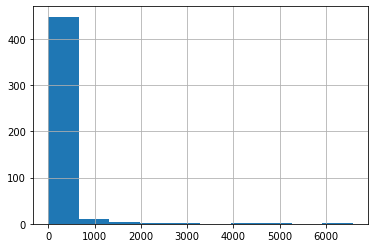

In [9]:
from numpy import linspace
df['geohashes_4'].value_counts().hist()
# df['geohash_count'].quantile(linspace(0,1,10)).plot(figsize=(12, 9))

Decile of the number of geohashes each listing contains

<AxesSubplot:>

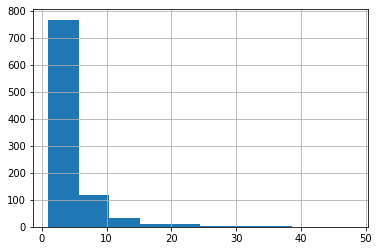

In [32]:
df['geohashes_5'].value_counts().hist()